<img src="https://www.vapulus.com/en/wp-content/uploads/2018/11/Qaiware-payment-magic-thegem-blog-default.jpg" />

This project was done to reconcile transactions of X company with its payments processor.

The aim is to amongst other things identify the:
- Proportion of transactions that were succesfully processed.
- Instances of duplicate transactions which can lead to loss of fund.
- Volume of transactions successfuly processed multiple times.
- Total amount paid as fees for mulptiple payouts.
- Total exposure of the company due to multiple payouts.

DISCLAIMER: The data here is not any real company information. Instead, they have been created to mimic real company data for the sake of this project. We used a combination of [fake name generator](https://www.fakenamegenerator.com/order.php) and applicable pandas built-in functions to manipulate the names and other sensitive details such as amount, account numbers, bank name. 

### Import Libraries and Load Data

In [1]:
#import python libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

In [2]:
# load manipulated data from my pc

df = pd.read_excel(r'C:\Users\user\OneDrive\Documents\KaoshiNetworkData\payments_data_audit.xlsx')

df.head(2)

,id,account_number,bank_code,fullname,date_created,currency,debit_currency,amount,fee,status,...,approver,complete_message,requires_approval,is_approved,bank_name,initiated_by,initiated_by_id,is_retry,can_retry,provider_ref
0,28760651,61704726,70,OZONNA AUGUSTINE CHIBUZOR,2022-06-20T08:25:53.000Z,NGN,NaN,181875.0,53.750,SUCCESSFUL,...,NaN,Transaction was successful,0,1,VITA BANK PLC,NaN,NaN,False,False,451040429339
1,28757584,10163596,57,CHUBBYLINKX,2022-06-20T07:22:34.000Z,NGN,NaN,125000.0,26.875,SUCCESSFUL,...,NaN,Transaction was successful,0,1,TOPMOST BANK PLC,NaN,NaN,False,False,451040371929


In [3]:
#check the data types and missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8853 entries, 0 to 8852
Data columns (total 25 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        8853 non-null   int64  
 1   account_number            8853 non-null   int64  
 2   bank_code                 8853 non-null   int64  
 3   fullname                  8853 non-null   object 
 4   date_created              8853 non-null   object 
 5   currency                  8853 non-null   object 
 6   debit_currency            138 non-null    object 
 7   amount                    8853 non-null   float64
 8   fee                       8853 non-null   float64
 9   status                    8853 non-null   object 
 10  reference                 8853 non-null   object 
 11  meta                      0 non-null      float64
 12  narration                 8695 non-null   object 
 13  requester_business_name   0 non-null      float64
 14  requeste

### Data Cleaning

Let us divide the provided dataset into three based on their transaction `status` as follows:
- dfs: succesful transactions
- dff: failed transactions
- dfp: pending transactions


In [4]:
# let us check of the transactions
display(df.status.value_counts())

#divide the dataframe by status
dfs = df.query('status =="SUCCESSFUL"')
dff = df.query('status =="FAILED"')
dfp = df.query('status =="PENDING"')

SUCCESSFUL    6149
FAILED        2702
PENDING          2
Name: status, dtype: int64

We dont need all the columns for this analysis; let us drop some columns.

- Empty columns: `meta`, `requester_business_name`, `requester_contact_person`, `approver`.
- Redundant columns: `currency` ,`debit_currency`, `bank_code`, `narration`, `initiated_by`, `initiated_by_id`, `provider_ref`.

In [5]:
#drop empty and unnneeded columns
warnings.filterwarnings('ignore')

dfs = (dfs.drop(columns = ['currency', 'debit_currency', 'meta', 'bank_code', 'requester_business_name', 'requester_contact_person',
                 'complete_message', 'approver', 'requires_approval', 'is_approved', 
                'initiated_by', 'initiated_by_id', 'is_retry', 'narration', 'can_retry', 'provider_ref']))


In [6]:
dfs.head()

,id,account_number,fullname,date_created,amount,fee,status,reference,bank_name
0,28760651,61704726,OZONNA AUGUSTINE CHIBUZOR,2022-06-20T08:25:53.000Z,181875.0,53.750,SUCCESSFUL,tx-4og31pvrd3,VITA BANK PLC
1,28757584,10163596,CHUBBYLINKX,2022-06-20T07:22:34.000Z,125000.0,26.875,SUCCESSFUL,tx-w2dq8nvwdp,TOPMOST BANK PLC
2,28751058,22271758,AISHA KELECHI UGWUEZUMBA,2022-06-20T04:17:02.000Z,72762.5,26.875,SUCCESSFUL,tx-z0grywypdx,JOINTED BANK FOR AFRICA PLC
3,28751046,21788220,CLINTON OKORUKU,2022-06-20T04:16:35.000Z,250000.0,53.750,SUCCESSFUL,tx-02eypv91ek,JOINTED BANK FOR AFRICA PLC
4,28748382,31066616,DIBIA INNOCENT,2022-06-20T00:58:41.000Z,72762.5,26.875,SUCCESSFUL,tx-w2dq8n8wdp,PRIME BANK PLC


Let us check for null values in the updated dataframe and drop rows with null values in `bank_name` and `provider_ref` columns.

In [7]:
#number of empty data cells in different columns
dfs.isnull().sum()

id                0
account_number    0
fullname          0
date_created      0
amount            0
fee               0
status            0
reference         0
bank_name         0
dtype: int64

In [8]:
#let us check data statistics
dfs.describe()

,id,account_number,amount,fee
count,6.149000e+03,6.149000e+03,6.149000e+03,6149.000000
mean,2.415906e+07,1.499060e+07,5.574472e+05,48.274476
std,3.023791e+06,1.873784e+07,5.460008e+05,11.047261
min,1.862384e+07,5.057000e+03,1.282500e+03,10.750000
25%,2.145016e+07,1.052096e+06,1.400500e+05,53.750000
50%,2.455343e+07,7.193937e+06,2.930000e+05,53.750000
75%,2.688678e+07,2.177834e+07,8.437500e+05,53.750000
max,2.876065e+07,9.302858e+07,2.500000e+06,53.750000


The `id`, `reference` and `provider_ref` columns each has 6149 unique values,

In [9]:
#check the number of unique elements in each of columns
dfs.nunique()

id                6149
account_number    1652
fullname          1629
date_created      6138
amount            2047
fee                  3
status               1
reference         6149
bank_name           21
dtype: int64

There are no columns with duplicate values. At this point, it looks like there are no multpile payouts. We will deepdive into the `id` and `reference` columns for possible duplicates.

In [12]:
#check columns with duplicates
dfs.loc[dfs.duplicated(), :]

,id,account_number,fullname,date_created,amount,fee,status,reference,bank_name


In [13]:
#duplicates in id column
print('duplicates in id column:', dfs.id.duplicated().sum())

#duplicates in reference column
print('duplicates in reference column:', dfs.reference.duplicated().sum())

duplicates in id column: 0
duplicates in reference column: 0


The possible unique identifier columns are `id` and `reference`. Let us assess more closely.

In [14]:
#id columns value are purely integers
dfs.id.sample(10)

8238    19606929
7449    20354140
6979    20933333
8527    19160709
1982    26779376
8622    18990399
7992    19990577
6070    22581169
1663    27082542
4432    25156991
Name: id, dtype: int64

We can see below that we can extract a unique identifier from the `reference` column by removing the prefix *tx* and suffixes.

In [15]:
#reference column values has prefix 'tx' and some suffices eg. '_3', '_8'
dfs.reference.sample(10)

2060            tx-oldw897kdz
427             tx-z0gr458odx
5539            tx-4og39jrrg3
4645            tx-w9glnnwze2
6566            tx-48epw42qg5
2009    tx-l8emz2v8gk_REFUND1
7313            tx-lmdzkpmmdk
2079            tx-poe7kmp7g0
1375            tx-57dk2119dw
6086            tx-w2dq7rj3gp
Name: reference, dtype: object

In [25]:
#define function to extract unique identifier
warnings.filterwarnings('ignore')

def clean_ref(data):
    data = data.split('-')[1]
    data = data.split('_')[0]
    return data

dfs['unique_id'] = dfs['reference'].apply(clean_ref)

print('Total succesful transactions:', dfs.reference.nunique())
print('Total unique transactions:', dfs.unique_id.nunique())
print('Duplicated (excess) transactions:', dfs[dfs.duplicated('unique_id')].shape[0])

Total succesful transactions: 6149
Total unique transactions: 6129
Duplicated (excess) transactions: 20


Let us divided the succesful transaction dataframe into two:
- dfs_dupl: transactions that are duplicated.
- dfs_singl: transactions that are not duplicated.

In [26]:
a = dfs.unique_id.value_counts()

#duplicated transactions
df_dupl = dfs[(dfs.unique_id.isin(a[a > 1].index))].sort_values('unique_id')

#non duplicated transactions
df_singl = dfs[~(dfs.unique_id.isin(a.index[a.gt(1)]))]

Let us have a quick preview of the duplicated transactions paying attention to the `fullname`, `amount`, `bank_name` and `date`. 
We now do a value counts on the `fullname` columns to see where a particular name appears more than once; and separate them from instances where the name appeared only once in the duplicated transactions dataframe *df_dupl*.

In [27]:
#check columns with duplicated fullname and unique_id

#duplicated names
v = df_dupl.fullname.value_counts()
df_dpay = df_dupl[df_dupl.fullname.isin(v[v > 1].index)]

#duplicated unique_id when name is duplicated
x = df_dpay.unique_id.value_counts()
df_dpay = df_dpay[df_dpay.unique_id.isin(x[x > 1].index)]

df_dpay.shape

(23, 10)

What we did to clean up the data:
- Explored the data for datatypes and completeness with `df.info()`.
- Dropped columns with missing data.
- Dropped columns that are not needed for th analysis.
- Extracted the unique identifier from the the `reference` column.
- Evaluated instances where `unique_id` occurs more than once.
- Sorted out when the `fullname` and `unique_id` are same and occurs more than once in the dataframe.

### Exploratory Data Analysis

Only about **70%** of the provided data are successful transactions.

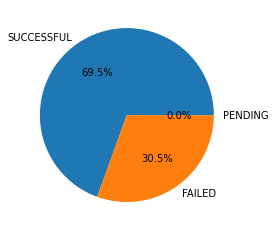

In [28]:
#proportion of the original dataset by transaction status

df.status.value_counts().plot(kind ='pie', autopct='%1.1f%%')
plt.ylabel('')
plt.show()

Proportion of the successful transactions that are duplicated.
- Duplicated successful transactions are instances where two different or similar transactions were processed with same `unique_id`. Two possiblities are (1) double payouts which is a potential loss and (2) split transaction where two beneficiaries share the sum amount of a unit transaction (no loss).
- Double payout occurs when a particular transaction is successfully processed twice in favour of same beneficuiary and for the same amount. This leads to loss of money.

In [29]:
print('Total of {} successful transactions.'.format(dfs.shape[0]))
print('Total of {} non-duplicated successful transactions.'.format(df_singl.shape[0]))
print('Total of {} duplicated successful transactions.'.format(df_dupl.shape[0]))
print('Total of {} unique successful transactions that were duplicated.'.format(df_dupl.unique_id.nunique()))
print('Only {}% succesful transactions were duplicated.'.format(round((df_dupl.shape[0]/dfs.shape[0])*100, 2)))
print('Total of {} double payouts.'.format(df_dpay.shape[0]))

Total of 6149 successful transactions.
Total of 6110 non-duplicated successful transactions.
Total of 39 duplicated successful transactions.
Total of 19 unique successful transactions that were duplicated.
Only 0.63% succesful transactions were duplicated.
Total of 23 double payouts.


Total volume and fees for the double payouts.

We first extract the duplicated rows using the `dataframe.duplicated()` function by `unique_id`.
Then we sum the `amount` and the `fee` to get the risk exposure due to double payout.

In [30]:
#five rows of the duplicates
df_dpay[df_dpay.duplicated('unique_id')].head()

,id,account_number,fullname,date_created,amount,fee,status,reference,bank_name,unique_id
585,28074959,78207359,Ogechukwu Ikwelle,2022-06-07T09:58:08.000Z,17270.0,26.875,SUCCESSFUL,tx-48ep8v0qg5_2,BETA BANK PLC,48ep8v0qg5
3892,26040009,306567,"BELLO, HAFIZ ADEBARI",2022-04-26T09:02:42.000Z,1437500.0,53.750,SUCCESSFUL,tx-75dn9xokek_3,ATBANK PLC,75dn9xokek
7694,20222500,12337801,caroline ADABUZO nmerem,2022-01-31T14:30:25.000Z,250000.0,53.750,SUCCESSFUL,tx-75dnko5kdk_3_RETRY_1,ASSET BANK NIGERIA,75dnko5kdk
6822,21274146,11017063,SEUN OPEYEMI TAOFEEK,2022-02-16T16:04:31.000Z,411750.0,53.750,SUCCESSFUL,tx-l3e41ynoev_3,SUGA,l3e41ynoev
3529,26302211,555840,RAJI MONSURAT,2022-04-30T12:13:23.000Z,142500.0,53.750,SUCCESSFUL,tx-l3e4xn5odv_8,ASSET BANK NIGERIA,l3e4xn5odv


In [31]:
print('Total amount deu to mulptiple payout',df_dpay[df_dpay.duplicated('unique_id')]['amount'].sum())

Total amount deu to mulptiple payout 8484745.0


In [32]:
print('Total fee due to mulptiple payout',df_dpay[df_dpay.duplicated('unique_id')]['fee'].sum())

Total fee due to mulptiple payout 618.125


The company is potentially losing N8,485,363.12 to double payments and the application transfer fees.

In [33]:
#sum of duplicated amount and fee
abd = round((df_dpay[df_dpay.duplicated('unique_id')]['amount'].sum() + df_dpay[df_dpay.duplicated('unique_id')]['fee'].sum()), 2)

print('Excess paid out including processing fee N',abd)

Excess paid out including processing fee N 8485363.12


### Export data as excel file

In [34]:
#df_dpay.to_excel(r'C:\Users\user\OneDrive\Documents\KaoshiNetworkData\multiple_payout_data.xlsx', index = False)